### 1 Import libraries

In [3]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from tqdm import tqdm
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import LocallyLinearEmbedding, MDS, TSNE
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import TruncatedSVD

# from mrmr import mrmr_classif

import matplotlib.pyplot as plt
import logging
logging.basicConfig(filename='logs/03_0_main pipeline.log', level=logging.INFO,
                     format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')


#colormap which is later used
colors = np.array([plt.cm.Dark2(0), plt.cm.Dark2(1), plt.cm.Dark2(2), plt.cm.Dark2(3)])

### 2 Import labels from excel

In [5]:
path_to_excel = "data/data_difumi.xlsx"

df = pd.read_excel(path_to_excel)
ids = df["Subject ID how it's defined in lab/project"].to_numpy()

y_sex = df["Sex of subject at birth (1-M, 2-F)"].to_numpy()
y_age = df["Age groups (1-60:79, 2-80:100+)"].to_numpy()
y_moca3 = df["MoCA groups (1-0:22, 2-23:25, 3-26+)"].to_numpy()
y_yrsed = df["Education groups (1-7:15, 2-16:18, 3-19+)"].to_numpy()
y_agr = df["Agreeableness quartiles (1-25, 2-50, 3-75)"].to_numpy()
y_con = df["Conscientiousness quartiles"].to_numpy()
y_ext = df["Extraversion quartiles2"].to_numpy()
y_neu = df["Neuroticism quartiles"].to_numpy()
y_ope = df["Openess quartiles"].to_numpy()

### 3 Import connectome, specify phenotype and feature selection

In [6]:
phenotype = 0
method = "tangent"
dimension_of_atlas = 64

max_ranked_features = 500
perform_selection = False

X = np.load("data/X_" + str(dimension_of_atlas) + "_" + method + ".npy")
print("X_" + str(dimension_of_atlas) + "_" + method + ".npy has been loaded.")

y_list = [y_sex, y_age, y_moca3,  y_yrsed, y_agr, y_con, y_ext, y_neu, y_ope]
y = y_list[phenotype]
print("Phenotype", phenotype, "has been loaded.")

try:
    ranked_features = list(np.load("data/" + str(max_ranked_features) + "_features_" + str(dimension_of_atlas) + "_" + method + "_phen_" + str(phenotype) +".npy"))
    print(str(max_ranked_features) + "_features_" + str(dimension_of_atlas) + "_" + method + "_phen_" + str(phenotype) + ".npy has been loaded.")
except OSError as e:
    if(perform_selection == True):
        print("Processing the features.")
        ranked_features = mrmr_classif(X=pd.DataFrame(X),
                                 y=pd.Series(y), K=max_ranked_features)
        np.save("data/" + str(max_ranked_features) + "_features_" + str(dimension_of_atlas) + "_" + method + "_phen_" + str(phenotype) +".npy", ranked_features)
        print(str(max_ranked_features) + "_features_" + str(dimension_of_atlas) + "_" + method + "_phen_" + str(phenotype) + ".npy has been saved.")
    else:
        print("MrMr features are not precomputed and perform_selection is False.")

X_64_tangent.npy has been loaded.
Phenotype 0 has been loaded.
500_features_64_tangent_phen_0.npy has been loaded.


### 4 Plot NCA

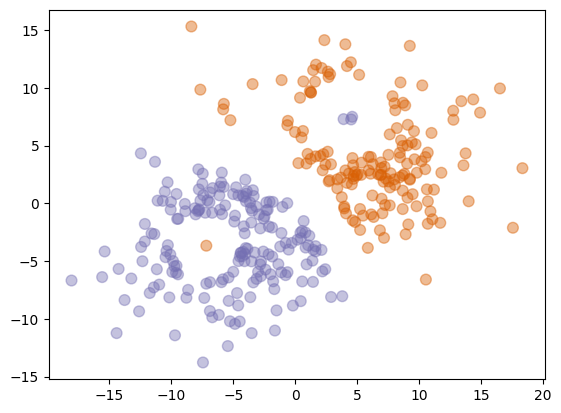

In [7]:
how_many_best_features = 200

transformer = NeighborhoodComponentsAnalysis(
        n_components=2, max_iter=500, init="pca", random_state=0)

x_plot, y_plot = transformer.fit_transform(X[:, ranked_features[:how_many_best_features]], y).T
plt.scatter(x_plot, y_plot, c=colors[y], alpha=0.425, s=60,)
plt.show()

### 5.1 NCA + k-NN classification (old way without nested CV)

In [12]:
how_many_best_features_list = [150, 200, 250]
results = []
param_grid = {
    "nca__n_components": [1, 3, 5, 7, 10, 15],
    "knn__n_neighbors": [1, 3, 5],
}
for how_many_best_features in how_many_best_features_list:
    cv = StratifiedShuffleSplit(n_splits=20, test_size=0.30,
                            random_state=0)
    Pipe = Pipeline(steps=[("nca", NeighborhoodComponentsAnalysis(init="pca", max_iter=500, random_state=0)),
                         ("knn", KNeighborsClassifier())])
    grid = GridSearchCV(Pipe, param_grid=param_grid, scoring='accuracy', 
                                   cv=cv,n_jobs=-1)
    
    grid.fit(X[:, ranked_features[:how_many_best_features]], y)
    string_for_print = "best_features: " + str(how_many_best_features) + " " + str(grid.best_params_) + " " + str(round(grid.best_score_,4)) + " +- " + str(round(grid.cv_results_['std_test_score'][grid.best_index_], 4))
    print(string_for_print)
    logging.info(string_for_print)

best_features: 150 {'knn__n_neighbors': 5, 'nca__n_components': 10} 0.8519 +- 0.0377
best_features: 200 {'knn__n_neighbors': 3, 'nca__n_components': 5} 0.8704 +- 0.027
best_features: 250 {'knn__n_neighbors': 3, 'nca__n_components': 15} 0.8782 +- 0.0352


### 5.2 NCA + k-NN classification (nested CV)

In [18]:
how_many_best_features = 200
results = []
param_grid = {
    "nca__n_components": [1, 3, 5, 7, 10, 15],
    "knn__n_neighbors": [1, 3, 5],
}

inner_cv = StratifiedShuffleSplit(n_splits=20, test_size=0.30,
                        random_state=0)
outer_cv = StratifiedShuffleSplit(n_splits=20, test_size=0.30,
                        random_state=0)
Pipe = Pipeline(steps=[("nca", NeighborhoodComponentsAnalysis(init="pca", max_iter=500, random_state=0)),
                        ("knn", KNeighborsClassifier())])
grid = GridSearchCV(Pipe, param_grid=param_grid, scoring='accuracy', 
                                cv=inner_cv,n_jobs=-1)
nested_score = cross_val_score(grid, X=X[:, ranked_features[:how_many_best_features]], y=y, cv=outer_cv)
score_outer_cv = nested_score.mean()
std_outer_cv = nested_score.std()

string_for_print = "score: " + str(round(score_outer_cv,4)) + " +- " + str(round(std_outer_cv, 4))
print(string_for_print)
logging.info(string_for_print)

score: 0.8684 +- 0.033


### 5.3 NCA + k-NN classification (split into train/test set, performance reported on hold-out set)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

for how_many_best_features in how_many_best_features_list:
    cv = StratifiedShuffleSplit(n_splits=20, test_size=0.30,
                            random_state=0)
    Pipe = Pipeline(steps=[("nca", NeighborhoodComponentsAnalysis(init="pca", max_iter=500, random_state=0)),
                         ("knn", KNeighborsClassifier())])
    grid = GridSearchCV(Pipe, param_grid=param_grid, scoring='accuracy', 
                                   cv=cv,n_jobs=-1)
    
    grid.fit(X_val[:, ranked_features[:how_many_best_features]], y_val)
    y_test_pred = grid.predict(X_test[:, ranked_features[:how_many_best_features]])
    prediction_on_holdout_set = accuracy_score(y_test, y_test_pred)
    
    string_for_print = "best_features: " + str(how_many_best_features) + " " + str(grid.best_params_) + " " + str(round(prediction_on_holdout_set,4))
    print(string_for_print)


best_features: 150 {'knn__n_neighbors': 5, 'nca__n_components': 7} 0.9143
best_features: 200 {'knn__n_neighbors': 3, 'nca__n_components': 7} 0.8857
best_features: 250 {'knn__n_neighbors': 1, 'nca__n_components': 10} 0.8857


### 6 Feature importance on the whole dataset

In [17]:
from sklearn.inspection import permutation_importance
# please chose model accordingly to which cell from above you are using.
model = grid

r = permutation_importance(grid, X[:, ranked_features[:how_many_best_features]], y, n_repeats=30, 
                            scoring = "accuracy",random_state=0)
print("Permutation feature importance score of features which have significant score (mean minus 2*std is > 0):")
print("If empty, then no feature is significant")
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2*r.importances_std[i] > 0:
        print(f"{(ranked_features[:how_many_best_features])[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")
print("\n")
print("Permutation feature importance score of all features")
for i in r.importances_mean.argsort()[::-1]:
        print(f"{(ranked_features[:how_many_best_features])[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

Permutation feature importance score of features which have significant score (mean minus 2*std is > 0):
If empty, then no feature is significant
1234    0.005 +/- 0.002
1607    0.003 +/- 0.001
637     0.003 +/- 0.001
1472    0.003 +/- 0.001
1743    0.003 +/- 0.001
2037    0.003 +/- 0.001
1932    0.003 +/- 0.001
627     0.003 +/- 0.001
1926    0.003 +/- 0.001
1378    0.003 +/- 0.001
983     0.003 +/- 0.001
1093    0.003 +/- 0.001
39      0.003 +/- 0.001
1477    0.003 +/- 0.001
1596    0.003 +/- 0.001
1963    0.003 +/- 0.001
1402    0.003 +/- 0.001
1997    0.003 +/- 0.001
1504    0.002 +/- 0.001
1220    0.002 +/- 0.001
509     0.002 +/- 0.001


Permutation feature importance score of all features
1762    0.005 +/- 0.003
1234    0.005 +/- 0.002
1182    0.004 +/- 0.004
1746    0.004 +/- 0.002
1887    0.004 +/- 0.002
9       0.004 +/- 0.002
1607    0.003 +/- 0.001
1508    0.003 +/- 0.002
637     0.003 +/- 0.001
1704    0.003 +/- 0.003
32      0.003 +/- 0.002
1472    0.003 +/- 0.001
1008   